![alt text](airbnb.png)
### Airbnb New User Booking


New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand. In this kaggle competition, Airbnb challenges you to predict in which country a new user will make his or her first booking. For more information please see [here](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings).

In [1]:
from imp import reload
import prepare_data
reload(prepare_data)
from prepare_data import *

### Data
In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. 

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014. In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. For more information please see [here](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data).

In [2]:
train, test, age_gender_bkts, countries, sessions = get_data()

In [3]:
print('The Size of the train data is: ', train.cache().count())
print('The Size of the test data is: ', test.cache().count())
print('The Size of the age_gender_bkts data is: ', age_gender_bkts.cache().count())
print('The Size of the countries data is: ', countries.cache().count())
#print('The Size of the sessions data is: ', sessions.cache().count())   

The Size of the train data is:  213451
The Size of the test data is:  62096
The Size of the age_gender_bkts data is:  420
The Size of the countries data is:  10


In [4]:
train.limit(4).toPandas()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other


In [5]:
train.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: timestamp (nullable = true)
 |-- timestamp_first_active: long (nullable = true)
 |-- date_first_booking: timestamp (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



In [6]:
test.limit(4).toPandas()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,None,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,None,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,None,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,None,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE


'country_destination' is the label variable

In [7]:
test.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: timestamp (nullable = true)
 |-- timestamp_first_active: long (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)



In [8]:
# There are 12 possible outcomes of the destination country:
# 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF', and 'other'
train.select('country_destination').distinct().count()

12

In [9]:
col_diff_list = list(set(train.columns) - set(test.columns))
print(col_diff_list)

['country_destination']


In [10]:
df = combine_train_test(train, test, col_diff_list)

In [11]:
print_missing(df)

id 0
date_account_created 0
timestamp_first_active 0
date_first_booking 186639
gender 0
age 116866
signup_method 0
signup_flow 0
language 0
affiliate_channel 0
affiliate_provider 0
first_affiliate_tracked 6085
signup_app 0
first_device_type 0
first_browser 0
country_destination 62096


0

In [12]:
mean_age = df.agg(F.mean(F.col('age'))).collect()[0][0]
df = df.fillna(mean_age,subset = ['age'])

In [13]:
print(round(100 *
            df.where(F.col('date_first_booking').isNull())
            .count()
      /df.count(),2),
      "% of the 'date_first_booking' is missing!")

67.73 % of the 'date_first_booking' is missing!


In [14]:
df.select('first_affiliate_tracked').distinct().show()

+-----------------------+
|first_affiliate_tracked|
+-----------------------+
|                   null|
|          tracked-other|
|              untracked|
|              marketing|
|              local ops|
|                 linked|
|                    omg|
|                product|
+-----------------------+



In [15]:
df = df.drop('id','date_first_booking','first_affiliate_tracked')    

In [16]:
df = parse_date(df,['date_account_created'])

In [17]:
# timestamp_first_active: timestamp of the first activity
df = get_datefromtimestamp_first_active(df)

In [18]:
df.limit(3).toPandas()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,date_account_createdyear,date_account_createdmonth,date_account_createddayofmonth,date_account_createddayofweek,first_active_year,first_active_month,first_active_day
0,-unknown-,47.14531,facebook,0,en,direct,direct,Web,Mac Desktop,Chrome,NDF,2010,6,28,2,2009,3,19
1,MALE,38.00000,facebook,0,en,seo,google,Web,Mac Desktop,Chrome,NDF,2011,5,25,4,2009,5,23
2,FEMALE,56.00000,basic,3,en,direct,direct,Web,Windows Desktop,IE,US,2010,9,28,3,2009,6,9


In [19]:
df.select('signup_app').distinct().show()

+----------+
|signup_app|
+----------+
|       iOS|
|     Moweb|
|   Android|
|       Web|
+----------+



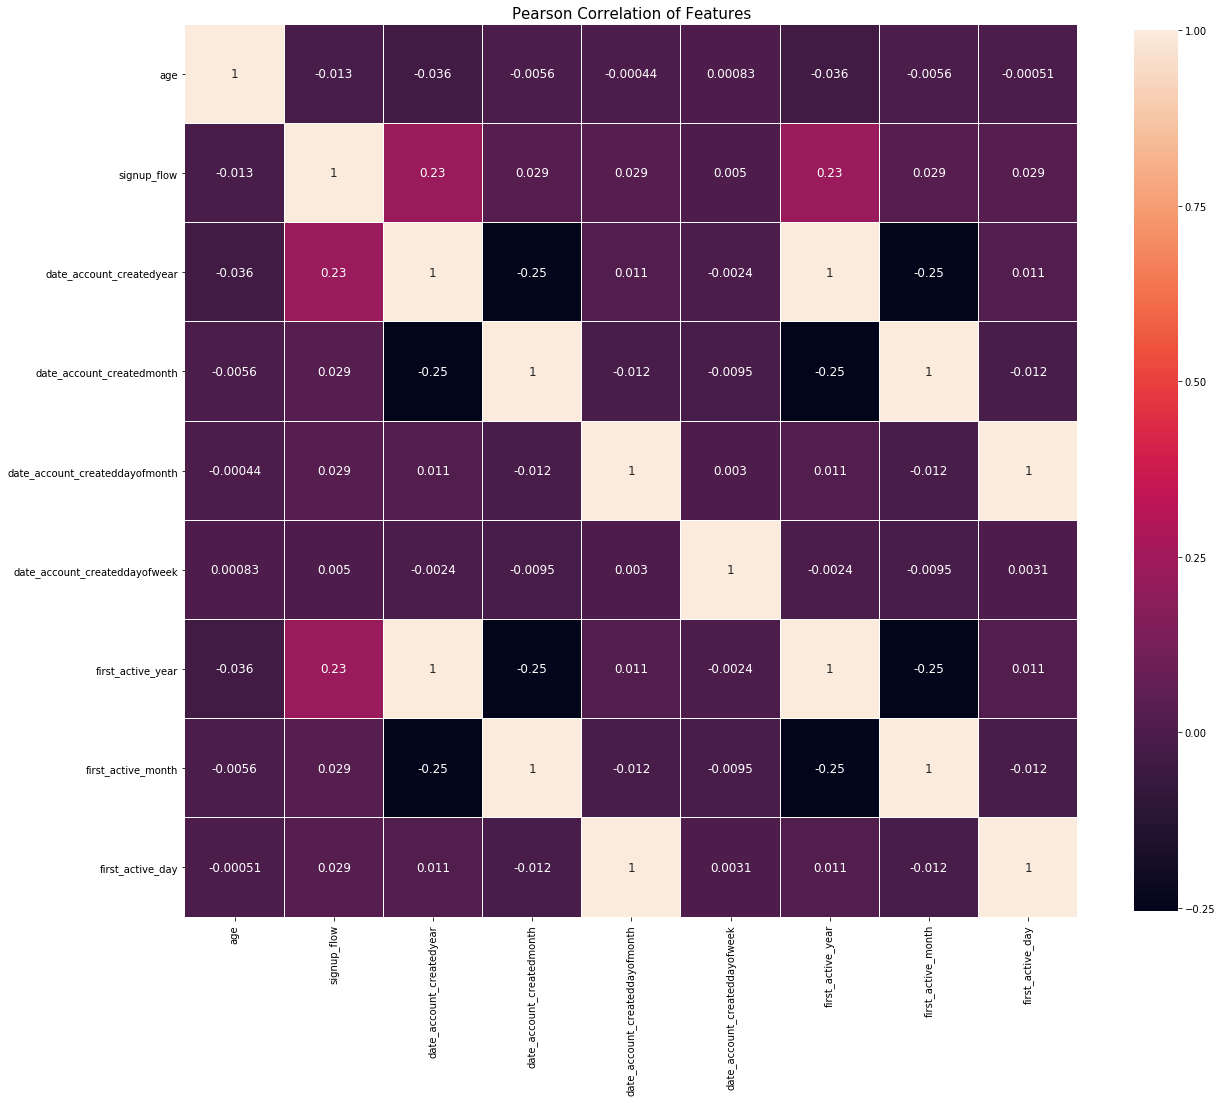

In [20]:
correlation_heatmap(df.toPandas())

There is a strong correlation between the following features:
- 'first_active_year' and 'date_account_createdyear'
- 'first_active_month' and 'date_account_createdmonth'
- 'first_active_day' and 'date_account_createdday'

In [21]:
df = df.drop('first_active_year', 'first_active_month', 'first_active_day')

## One Hot Encoding   

In [22]:
categorical_features = [col for col in df.columns if df.select(col).dtypes[0][1] == 'string']
categorical_features.append('signup_flow')
categorical_features.remove('country_destination')

In [23]:
df = one_hot_encoding(df, categorical_features)

In [24]:
df.cache().count()

275547

In [25]:
ctry = ['US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF']
for country in ctry:    
    df = df.withColumn('country_destination_index_'+country, F.expr('IF((country_destination = "{country}"), 1, 0)'.format(country=country)))

In [26]:
df_train = df.where((F.col('country_destination').isNotNull()))
df_test = df.where((F.col('country_destination').isNull()))

In [27]:
features_to_drop = [col for col in df.columns if df.select(col).dtypes[0][1] == 'string']
features_to_drop.append('signup_flow')

In [28]:
features_list = df.drop(*categorical_features,*features_to_drop).columns

In [29]:
tmp = features_list[14:26]
features_list = list(set(features_list) - set(tmp))

## Spark ML

In [30]:
train_cv, test_cv = df_train.randomSplit([0.8,0.2], seed = 42)

In [31]:
models = ['Logestic Regression', 'Random Forest', 'Naive Baise']
accuracy_list = []
for c in ctry[1:12]:
    model = RandomForestClassifier(featuresCol='features',labelCol= 'country_destination_index_'+c)
    assembler = VectorAssembler(inputCols= features_list, outputCol='features')
    pipeline = Pipeline(stages=[assembler, model])
    model = pipeline.fit(train_cv)
    prediction = model.transform(test_cv)
    evaluator = MulticlassClassificationEvaluator(
    labelCol="country_destination_index_"+c,
    predictionCol="prediction",
    metricName="accuracy")
    accuracy = evaluator.evaluate(prediction)
    accuracy_list.append(accuracy)
    
    print("For country: "+c,"Test Error = %g " % (1.0 - accuracy))


print("Mean Error: ", 1.0 - np.mean(accuracy_list))    

For country: FR Test Error = 0.0237535 
For country: CA Test Error = 0.00708602 
For country: GB Test Error = 0.0112058 
For country: ES Test Error = 0.0106408 
For country: IT Test Error = 0.0131362 
For country: PT Test Error = 0.00103583 
For country: NL Test Error = 0.00306041 
For country: DE Test Error = 0.00517915 
For country: AU Test Error = 0.00303687 
For country: NDF Test Error = 0.334503 
Mean Error:  0.041263712980837086


### A simple label encoding with NDCG evaluation

The evaluation metric for this competition is **NDCG (Normalized discounted cumulative gain) @k**. For more information please see [here](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview/evaluation).

In [37]:
indexer = StringIndexer(inputCol="country_destination", outputCol="country_destination_indexed",handleInvalid="keep")
df = indexer.fit(df).transform(df)

In [38]:
df_train = df.where((F.col('country_destination').isNotNull()))
df_test = df.where((F.col('country_destination').isNull()))

In [43]:
train_cv, test_cv = df_train.randomSplit([0.8,0.2], seed = 42)

In [44]:
models = ['Logestic Regression', 'Random Forest', 'Naive Baise']

for i in range(1):
    prediction = build_models(i,'country_destination_indexed', features_list,train_cv, test_cv)
    print("model ", i, "results: ", pred_precision_kaggle(prediction, 5))


model  0 results:  0.9415226705588776
